In [114]:
from pyspark.sql import SparkSession
df = spark.read.csv('out.csv', header='true', inferSchema = True)
df = df.drop(df._c0)
df.show(2)

+----------+----+----+---+-----+-------+-------+
|      Date|Open|High|Low|Close| Volume|OpenInt|
+----------+----+----+---+-----+-------+-------+
|      Date|Open|High|Low|Close| Volume|OpenInt|
|2015-11-11|18.5|25.9| 18| 24.5|1584600|      0|
+----------+----+----+---+-----+-------+-------+
only showing top 2 rows



In [115]:
df.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Open: string (nullable = true)
 |-- High: string (nullable = true)
 |-- Low: string (nullable = true)
 |-- Close: string (nullable = true)
 |-- Volume: string (nullable = true)
 |-- OpenInt: string (nullable = true)



In [116]:
df.count()

14894828

In [117]:
df.summary().show()

+-------+----------+------------------+------------------+------------------+------------------+-----------------+--------+
|summary|      Date|              Open|              High|               Low|             Close|           Volume| OpenInt|
+-------+----------+------------------+------------------+------------------+------------------+-----------------+--------+
|  count|  14894828|          14894828|          14894828|          14894828|          14894828|         14894828|14894828|
|   mean|      null|30385.382295753818|31212.467319554504|29361.760762005706|30245.218346697882|1585730.317615086|     0.0|
| stddev|      null|   4202500.9537511| 4323485.549288446|4046981.0035714786|4180590.0656643286|7635186.712274293|     0.0|
|    min|1962-01-02|                 0|             0.004|                -1|            0.0037|                0|       0|
|    25%|      null|              7.75|            7.8841|            7.6098|              7.75|          32800.0|     0.0|
|    50%

In [118]:
import pyspark.sql.functions as funcs

df.groupBy(df.columns).count().where(funcs.col('count') > 1).select(funcs.sum('count')).show()
df.dropDuplicates()

+----------+
|sum(count)|
+----------+
|      7556|
+----------+



DataFrame[Date: string, Open: string, High: string, Low: string, Close: string, Volume: string, OpenInt: string]

In [119]:
#Get All column names and it's types
for field in df.schema.fields:
    print(field.name +" === "+str(field.dataType))

Date === StringType
Open === StringType
High === StringType
Low === StringType
Close === StringType
Volume === StringType
OpenInt === StringType


In [120]:
from pyspark.sql import functions as F
df= df.withColumn('Date',F.to_date(df.Date))

x = ['Open', 'High', 'Low', 'Close', 'Volume']
for col in x:
    df = df.withColumn(col, df[col].cast('float'))

In [121]:
df = df.drop(df.OpenInt)
df = df.dropna()

In [122]:
from pyspark.sql.functions import col, skewness, kurtosis
var = 'Close'
df.select(skewness(var),kurtosis(var)).show()

+------------------+------------------+
|   skewness(Close)|   kurtosis(Close)|
+------------------+------------------+
|203.74074934725854|46738.841837468244|
+------------------+------------------+



In [123]:
df1 = df.filter(F.col("Date").between('2008-11-11','2011-11-11'))
df2 = df1.toPandas()

## Stationarity Test on Sample Data

In [124]:
df4 = df2.head(1000)

### Augmented Dickey Fuller Test

In [125]:
from statsmodels.tsa.stattools import adfuller
z = ['Open', 'High', 'Low', 'Close', 'Volume']
for col in z:
    result = adfuller(df4[col], autolag='AIC')
    print('ADF For:', col)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')

ADF For: Open
ADF Statistic: -1.8769081502477845
p-value: 0.3430009899995077
Critial Values:
   1%, -3.436972562223603
Critial Values:
   5%, -2.864463856182476
Critial Values:
   10%, -2.5683268054280175
ADF For: High
ADF Statistic: -1.7477251838537944
p-value: 0.40670577541910413
Critial Values:
   1%, -3.4369994990319355
Critial Values:
   5%, -2.8644757356011743
Critial Values:
   10%, -2.5683331327427803
ADF For: Low
ADF Statistic: -1.7022507327335632
p-value: 0.4299532063515705
Critial Values:
   1%, -3.4369927443074353
Critial Values:
   5%, -2.864472756705845
Critial Values:
   10%, -2.568331546097238
ADF For: Close
ADF Statistic: -1.7016118983218453
p-value: 0.430282170307627
Critial Values:
   1%, -3.4369927443074353
Critial Values:
   5%, -2.864472756705845
Critial Values:
   10%, -2.568331546097238
ADF For: Volume
ADF Statistic: -4.055874877949525
p-value: 0.0011445985642746092
Critial Values:
   1%, -3.436959175494265
Critial Values:
   5%, -2.8644579524531975
Critial Valu

### Kwiatkowski-Phillips-Schmidt-Shin test 
- Null Hypothesis, H0: The time series is stationary.
- Alternative Hypothesis, H1: The time series is not stationary.

In [126]:
# Import kpss
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
for col in z:
    result = kpss(df4[col])
    print(result)
    print('KPSS Test Statistic: %.2f' % result[0])
    print('5%% Critical Value: %.2f' % result[3]['5%'])
    print('p-value: %.2f' % result[1])

(1.0785901562298206, 0.01, 19, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
KPSS Test Statistic: 1.08
5% Critical Value: 0.46
p-value: 0.01
(1.0871246274722606, 0.01, 19, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
KPSS Test Statistic: 1.09
5% Critical Value: 0.46
p-value: 0.01
(1.0690032893139316, 0.01, 19, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
KPSS Test Statistic: 1.07
5% Critical Value: 0.46
p-value: 0.01
(1.0773540218788233, 0.01, 19, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
KPSS Test Statistic: 1.08
5% Critical Value: 0.46
p-value: 0.01
(3.0934670838170404, 0.01, 18, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
KPSS Test Statistic: 3.09
5% Critical Value: 0.46
p-value: 0.01


## Data Ploting
### to read
- https://towardsdatascience.com/neat-time-series-aggregations-with-core-pyspark-4a739953076a

In [127]:
# import plotly.express as px
# figure = px.bar(df2, x = df2.Date, 
#                  y = df2["Close"],
#                  title = "Time Series Analysis of Closing Stock Price (Line Plot)" )
# figure.show()

## Moving Average Plot on Sample Data

In [128]:
from __future__ import division
from pylab import plot, ylim, xlim, show, xlabel, ylabel, grid
from numpy import linspace, loadtxt, ones, convolve
import numpy as numpy

df3 = df4.head(700)
def movingaverage(interval, window_size):
    window= numpy.ones(int(window_size))/float(window_size)
    return numpy.convolve(interval, window, 'same')


Text(0, 0.5, 'Closing of the stocks')

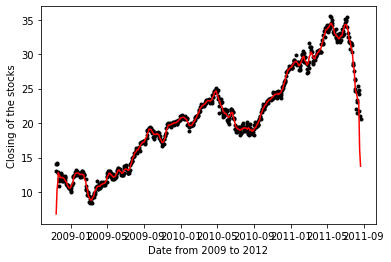

In [129]:
plot(df3['Date'],df3['Close'],"k.")
x = df3['Date']
y_av = movingaverage(df3['Close'], 10)
plot(x, y_av,"r")
xlabel("Date from 2009 to 2012")
ylabel("Closing of the stocks")


Text(0, 0.5, 'Volume of the stocks')

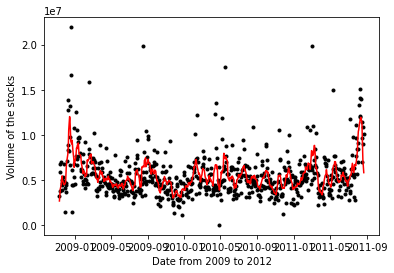

In [130]:
plot(df3['Date'],df3['Volume'],"k.")
x = df3['Date']
y_av = movingaverage(df3['Volume'], 10)
plot(x, y_av,"r")
xlabel("Date from 2009 to 2012")
ylabel("Volume of the stocks")

Text(0, 0.5, 'Volume of the stocks')

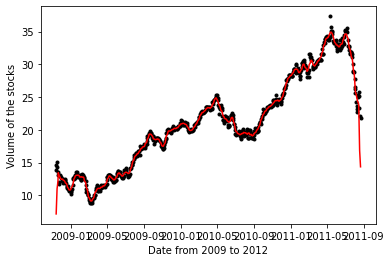

In [131]:
plot(df3['Date'],df3['High'],"k.")
x = df3['Date']
y_av = movingaverage(df3['High'], 10)
plot(x, y_av,"r")
xlabel("Date from 2009 to 2012")
ylabel("Volume of the stocks")

### Percentage Plot

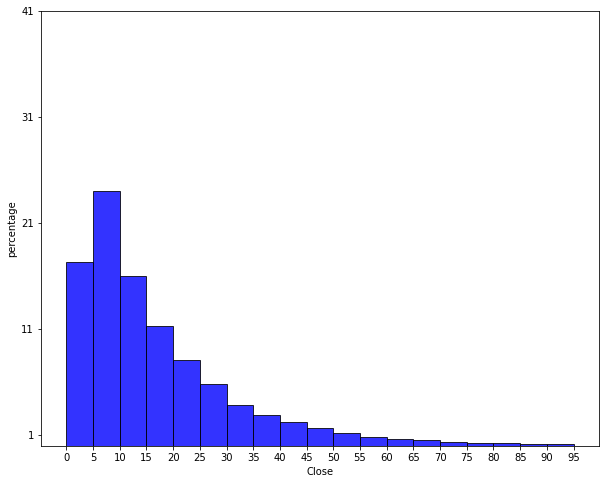

In [132]:
import numpy as np
import matplotlib.pyplot as plt
var = 'Close'
x = df2[var]
bins = np.arange(0, 100, 5.0)

plt.figure(figsize=(10,8))
# the histogram of the data
plt.hist(x, bins, alpha=0.8, histtype='bar', color='blue',
         ec='black',weights=np.zeros_like(x) + 100. / x.size)
plt.xlabel(var)
plt.ylabel('percentage')
plt.xticks(bins)
plt.yticks(range(1,50,10))
plt.show()


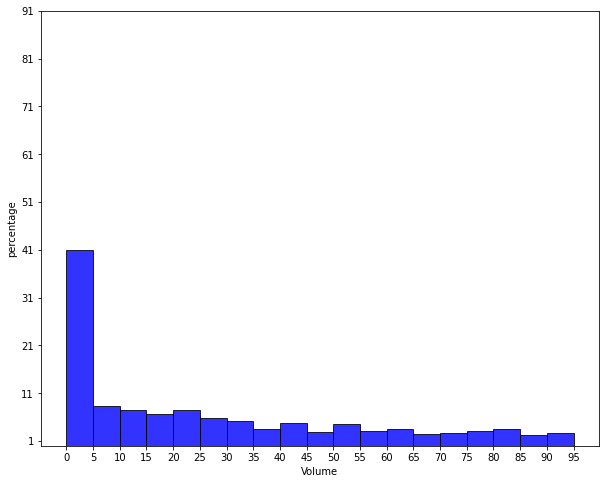

In [133]:
import numpy as np
import matplotlib.pyplot as plt
var = 'Volume'
x = df2[var]
bins = np.arange(0, 100, 5.0)

plt.figure(figsize=(10,8))
# the histogram of the data
plt.hist(x, bins, alpha=0.8, histtype='bar', color='blue',
         ec='black',weights=np.zeros_like(x) + 20000. / x.size)
plt.xlabel(var)
plt.ylabel('percentage')
plt.xticks(bins)
plt.yticks(range(1,101,10))
plt.show()

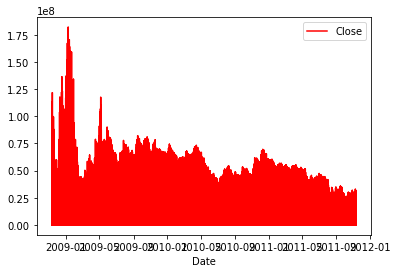

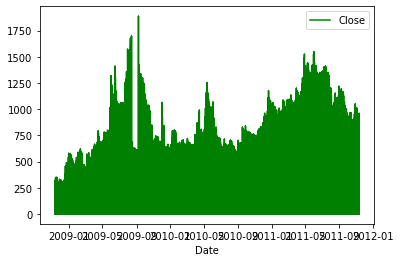

In [134]:
import pandas as pd
df12 = df2.reset_index()
df12['Date'] = pd.to_datetime(df12['Date'])
#  Plotting date vs the close market stock price
df2.plot('Date','Close',color="red")
 
# # Extract only top 100000 rows to make the plot a little clearer
new_data = df2.head(100000)
 
#  Plotting date vs the close  market stock price
new_data.plot('Date','Close',color="green")
 
plt.show()

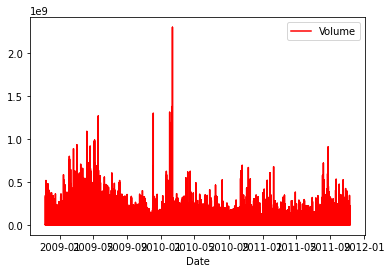

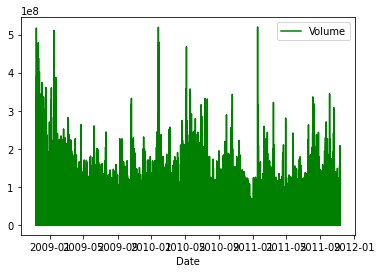

In [135]:
#  Plotting date vs the close market stock price
df2.plot('Date','Volume',color="red")
 
# # Extract only top 100000 rows to make the plot a little clearer
new_data = df2.head(100000)
 
#  Plotting date vs the close  market stock price
new_data.plot('Date','Volume',color="green")
 
plt.show()

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

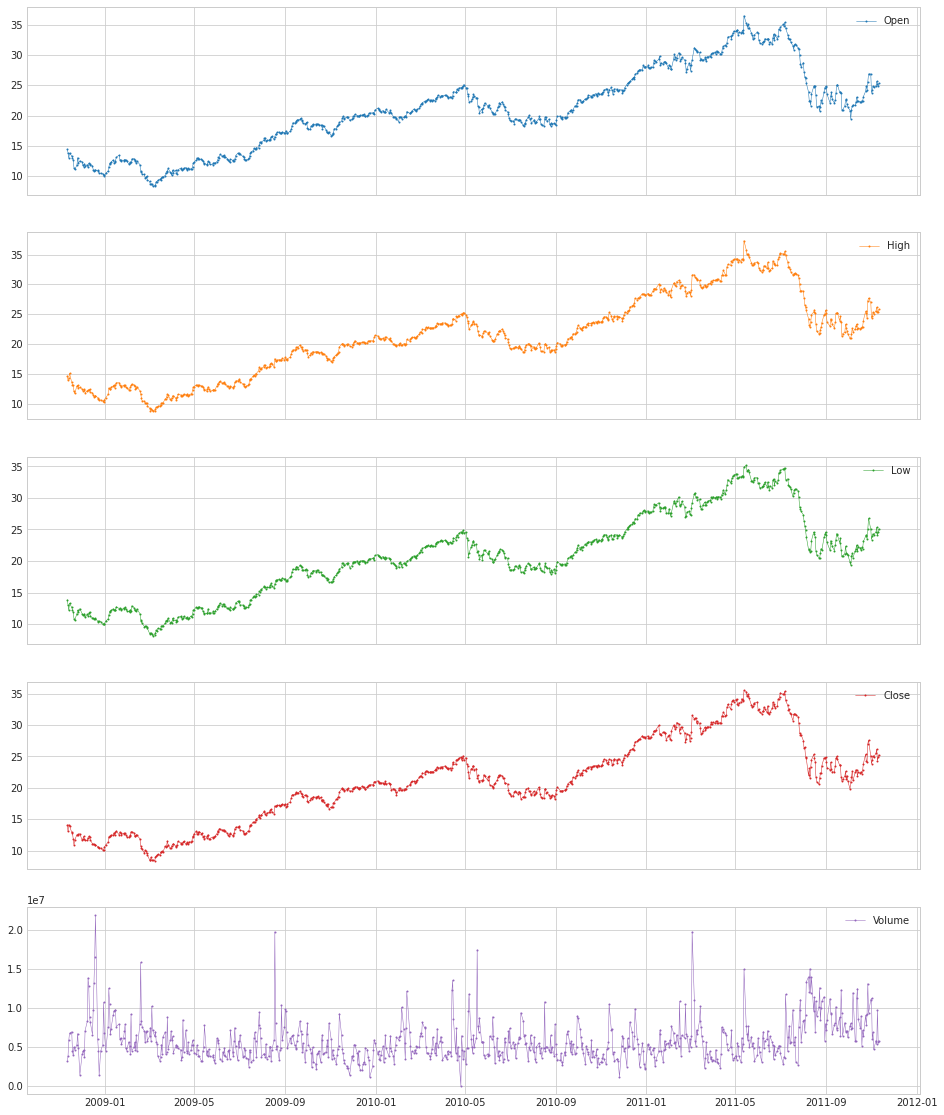

In [136]:
from adtk.data import validate_series
from adtk.visualization import plot
import pandas as pd
df12 = df12.set_index('Date')
df12 = validate_series(df12)
df12 = df12.drop('index', axis = 1)
plot(df12)

### Anamoly ploting by taking the mean, min and max of the data an

Average closing price 21.000011
Minimum closing price 8.3975
Maximum closing price 35.496


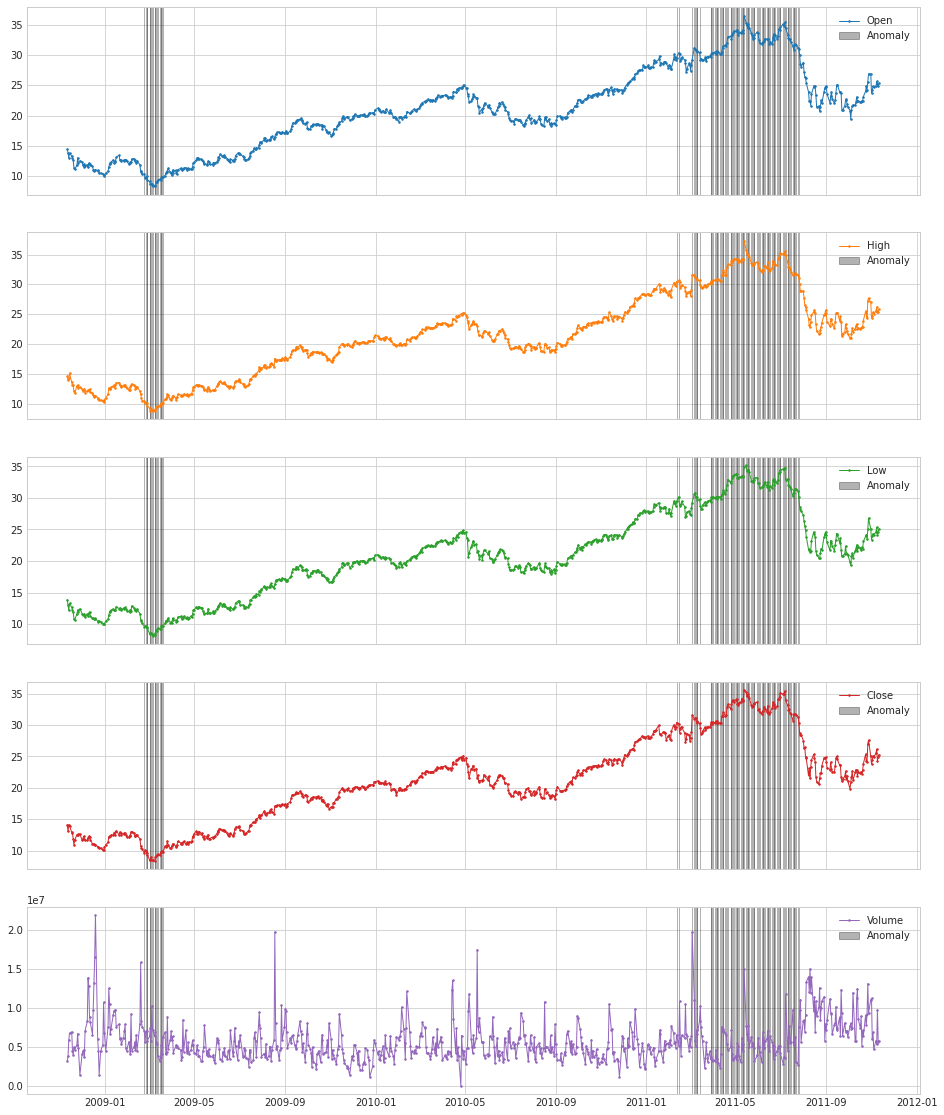

In [138]:
print('Average closing price', df12['Close'].mean())
print('Minimum closing price', df12['Close'].min())
print('Maximum closing price',df12['Close'].max())
from adtk.detector import ThresholdAD
threshold_val = ThresholdAD(high=30, low=10)
anomalies_thresh = threshold_val.detect(df12['Close'])
anomalies_thresh.value_counts()
plot(df12, anomaly=anomalies_thresh, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='black');

### Multicollinearity Test

            Open      High       Low     Close    Volume
Open    1.000000  0.998967  0.998735  0.998094 -0.003111
High    0.998967  1.000000  0.997981  0.998956 -0.003099
Low     0.998735  0.997981  1.000000  0.999112 -0.003127
Close   0.998094  0.998956  0.999112  1.000000 -0.003115
Volume -0.003111 -0.003099 -0.003127 -0.003115  1.000000


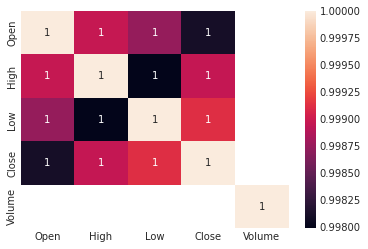

In [139]:
import seaborn as sns
x = df2.corr()
sns.heatmap(x, mask=(x < 0.01), annot= True)
print(x)

### IQR Method

In [141]:
column_subset = ['Open', 'High', 'Low', 'Close', 'Volume']
for col_ in column_subset:
    if df.select(col_).dtypes[0][1]=="string":
        pass
    else:
        q1,q3 = df.approxQuantile(col_,[0.25, 0.75],0) 
        IQR = q3 - q1
        lower_bound = q1 - (1.5*IQR)
        upper_bound = q3 + (1.5*IQR)
        df = df.filter((df[col_]>lower_bound) & (df[col_]<upper_bound))

## Linear Regression

In [142]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols = ['Volume' ], outputCol = 'features')
output = assembler.transform(df)
final_df = output.select('features', 'Close')
final_df = final_df.selectExpr('features', 'Close AS label')
train_data, test_data = final_df.randomSplit([0.7,0.3])

In [143]:
final_df.show(5)

+-----------+-----+
|   features|label|
+-----------+-----+
|[1584600.0]| 24.5|
|  [83000.0]| 25.0|
|  [67300.0]|25.26|
|  [16900.0]|25.02|
|  [25900.0]|24.62|
+-----------+-----+
only showing top 5 rows



In [144]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(regParam=0.3, elasticNetParam=0.8)
lrModel = lr.fit(train_data)
# Print the coefficients and intercept for linear regression
print("Coefficients: %s for training data" % str(lrModel.coefficients))
print("Intercept: %s for training data" % str(lrModel.intercept))

# Summarize the model over the training set and print out some metrics
trainingSummary = lrModel.summary
# print("numIterations: %d" % trainingSummary.totalIterations)
# print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
print("RMSE: %f for training data" % trainingSummary.rootMeanSquaredError)
# print("r2: %f for training data" % trainingSummary.r2)

Coefficients: [3.350166300186628e-06] for training data
Intercept: 14.899283629098996 for training data
RMSE: 11.386426 for training data


In [145]:
res = lrModel.evaluate(test_data)
unlabeled_data = test_data.select('features')
predictions = lrModel.transform(unlabeled_data)
print('MAE: for testing data', res.meanAbsoluteError)
print('MSE: for testing data', res.meanSquaredError)
print('RMSE for testing data:', res.rootMeanSquaredError)

MAE: for testing data 9.284380900905703
MSE: for testing data 129.47000945427598
RMSE for testing data: 11.378488891512616


## Cross Validation Testing 

In [146]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
lr = LinearRegression(regParam=0.3, elasticNetParam=0.8)
grid = ParamGridBuilder().addGrid(lr.maxIter, [1, 10]).build()
evaluator = RegressionEvaluator()
cv = CrossValidator(estimator=lr, estimatorParamMaps=grid, evaluator=evaluator,
    parallelism=2)
cvModel = cv.fit(train_data)
cvModel.getNumFolds()
evaluator.evaluate(cvModel.transform(test_data))

11.378488891512616

## Decision Tree

In [150]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator
Dr = DecisionTreeRegressor(labelCol='label')
drModel = Dr.fit(train_data)
# Make predictions.
predictions = drModel.transform(test_data)

# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="r2")
rmse1 = evaluator.evaluate(predictions)
print("R- Squared on test data = %g" % rmse1)

Root Mean Squared Error (RMSE) on test data = 11.3317


R- Squared on test data = 0.0299788


## Random Forest


In [152]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
# Train a RandomForest model.
rf = RandomForestRegressor(labelCol='label')

# Chain indexer and forest in a Pipeline
pipeline = Pipeline(stages=[rf])

# Train model.  This also runs the indexer.
model = pipeline.fit(train_data)

# Make predictions.
predictions = model.transform(test_data)

# Select example rows to display.
predictions.select("prediction", "label", "features")

# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 11.3312


## Gradient boosting regressor

In [154]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import GBTRegressor
# Train a GBT model.
gbt = GBTRegressor(featuresCol="features", maxIter=10,labelCol='label')

# Chain indexer and GBT in a Pipeline
# pipeline = Pipeline(stages=[gbt])

# Train model.  This also runs the indexer.
model = gbt.fit(train_data)

# Make predictions.
predictions = model.transform(test_data)

# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 11.3312
